## Python 3.11.9
Pycaret não funcionar em versão superior à 3.11 do Python

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools
from datetime import datetime
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, confusion_matrix)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (RandomUnderSampler, TomekLinks, ClusterCentroids)
from imblearn.combine import (SMOTEENN, SMOTETomek)
from collections import Counter

In [5]:
df_features_selecionados = pd.read_excel("dados/dados_processados_selecionados.xlsx", engine='openpyxl')
df_todas_features = pd.read_excel("dados/dados_processados.xlsx", engine='openpyxl')

df = df_todas_features
df, df_validacao = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
# Funções utilitárias usadas no notebook
def verificar_distribuicao(y, descricao):
    print(f"Distribuição {descricao}: {Counter(y)}")

def balancear_avaliar(nome, metodo, X_train, y_train, X_test, y_test):
    try:
        print(f"\nMétodo: {nome}")
        X_resampled, y_resampled = metodo.fit_resample(X_train, y_train)
        verificar_distribuicao(y_resampled, f"após {nome}")
        modelo = RandomForestClassifier(random_state=42)
        modelo.fit(X_resampled, y_resampled)
        y_pred = modelo.predict(X_test)
        #print(classification_report(y_test, y_pred))
        return classification_report(y_test, y_pred, output_dict=True)
    except Exception as e:
        print(f"Erro no método {nome}: {e}")
        return None
    

def preprocessar_dados(df, target, features=df.columns.tolist()):
    """
    Normaliza os dados e separa treino e teste.
    
    Parâmetros:
        df (pd.DataFrame): DataFrame com os dados.
        target (str): Nome da variável resposta.
        features (list): Lista das colunas de features.
    
    Retorna:
        X_train, X_test, y_train, y_test: Dados divididos para treino e teste.
    """
    df = df.copy()  # Evita alterar o original
    if df[target].dtype == "object":
        df[target] = LabelEncoder().fit_transform(df[target])  # Codifica target se categórico
    X = df[features]  # Seleciona features
    y = df[target]    # Seleciona target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y )  # Split
    return X_train, X_test, y_train, y_test

In [7]:
features_numericas = ['idade', 'peso', 'altura', 'vestimenta', 'tmedia', 'tmax',
       'tmin', 'tu', 'ur', 'ur_max', 'ur_min', 'rsolarmed', 'rsolartot',
       'vel_vento', 'dir_vento', 'sd_dirvento', 'vel_vento_max',
       'dir_max_vento', 'chuva_tot']

features_categoricas=['sexo_encod']

features = features_numericas + features_categoricas 

features_data=['data','hora','data_cplt']

['sexo_encod', 'rsolarmed', 'dir_max_vento', 'vestimenta', 'mes-ano_encod']

['sexo_encod', 'rsolarmed', 'dir_max_vento', 'vestimenta', 'mes-ano_encod']

In [8]:
X_train, X_test, y_train, y_test= preprocessar_dados(df, 'p1',features_numericas + features_categoricas)

In [9]:
X_train

,idade,peso,altura,vestimenta,tmedia,tmax,tmin,tu,ur,ur_max,ur_min,rsolarmed,rsolartot,vel_vento,dir_vento,sd_dirvento,vel_vento_max,dir_max_vento,chuva_tot,sexo_encod
338,51,80,170,0.5,26.57,26.74,26.45,23.910000,38.35,40.07,38.08,440.700000,264.410,2.48,82.7,36.66,5.83,97.60,0.0,1
929,22,70,172,0.5,32.25,32.45,32.09,22.920000,47.36,48.62,46.11,939.000000,563.120,0.12,153.7,25.08,1.03,145.80,0.0,1
292,60,89,172,0.5,24.44,24.51,24.38,22.310000,45.66,47.22,45.53,55.190000,33.110,1.69,83.8,38.71,7.10,93.30,0.0,1
624,40,68,157,0.5,28.27,28.36,28.18,25.200000,34.03,34.57,33.80,593.900000,356.350,2.16,114.3,48.37,7.18,104.70,0.0,0
1694,20,57,164,1.0,19.04,19.13,18.97,12.705929,48.71,49.76,48.10,198.300000,118.960,0.01,203.6,0.36,0.35,201.70,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,23,82,175,0.5,25.15,25.27,25.04,23.920000,69.69,69.69,67.46,411.600000,246.950,0.02,218.3,6.48,0.43,182.10,0.0,1
1546,23,80,165,1.0,18.13,18.35,17.96,10.699384,39.26,40.07,38.65,83.300000,49.950,0.88,173.9,21.19,2.08,184.10,0.0,0
1351,29,56,152,2.0,10.82,10.95,10.68,9.553681,88.30,89.40,88.10,642.474286,385.468,0.21,163.0,10.97,1.18,170.50,0.1,0
866,50,73,166,0.5,22.36,22.53,22.13,19.140000,80.40,82.10,80.40,46.190000,27.710,0.00,0.0,0.00,0.00,30.84,0.0,1


# 1. Balanceamento

Distribuição original do conjunto de treino: Counter({0: 353, 2: 318, 1: 241, 3: 165, -1: 105, -2: 48, -3: 8})

Modelo sem balanceamento
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         2
          -2       0.29      0.33      0.31        12
          -1       0.28      0.35      0.31        26
           0       0.43      0.46      0.45        89
           1       0.31      0.25      0.28        60
           2       0.38      0.39      0.39        80
           3       0.56      0.54      0.55        41

    accuracy                           0.39       310
   macro avg       0.32      0.33      0.32       310
weighted avg       0.39      0.39      0.39       310


Método: Random Oversampling
Distribuição após Random Oversampling: Counter({1: 353, 3: 353, 0: 353, 2: 353, -1: 353, -2: 353, -3: 353})
              precision    recall  f1-score   support

          -3       0.50      0.50      0.50         2
          -2       0

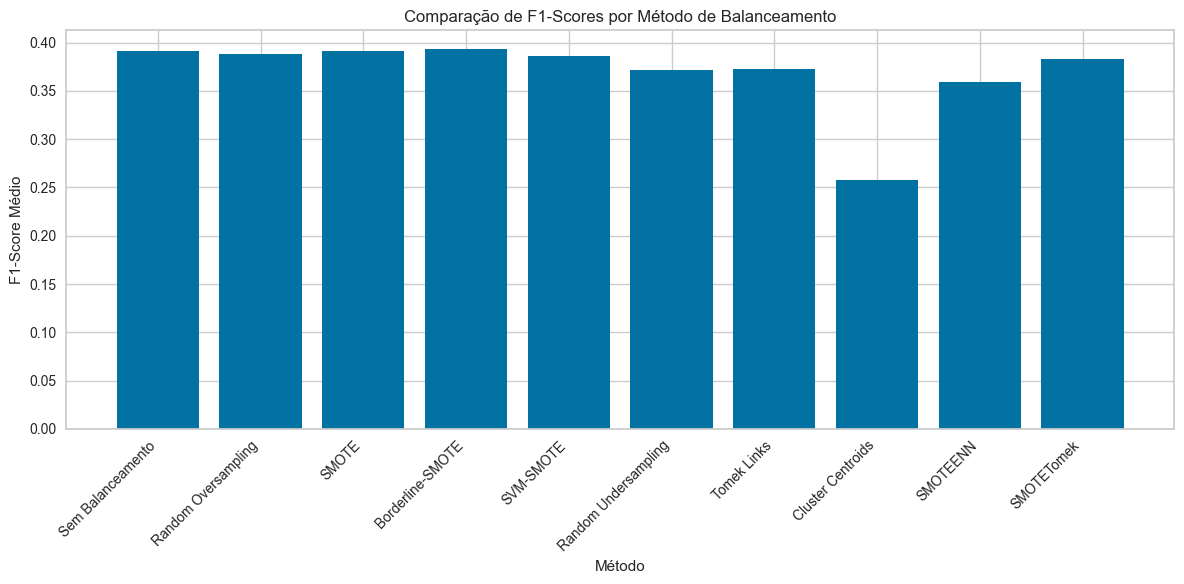

In [10]:

# Pré-processamento
# Codificar a variável categórica 'sexo'
#df_inteiro['sexo'] = LabelEncoder().fit_transform(df_inteiro['sexo'])

# Separar as variáveis independentes e a resposta
X = df.drop('p1', axis=1)
y = df['p1']

# Divisão treino-teste

# Verificar a distribuição original

verificar_distribuicao(y_train, "original do conjunto de treino")


# Avaliar modelo sem balanceamento
print("\nModelo sem balanceamento")
modelo_original = RandomForestClassifier(random_state=42)
modelo_original.fit(X_train, y_train)
y_pred_original = modelo_original.predict(X_test)
resultado_original = classification_report(y_test, y_pred_original, output_dict=True)
print(classification_report(y_test, y_pred_original))

# Lista de métodos de balanceamento
metodos = {
    "Random Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "Borderline-SMOTE": BorderlineSMOTE(random_state=42),
    "SVM-SMOTE": SVMSMOTE(random_state=42),
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "Tomek Links": TomekLinks(),
    "Cluster Centroids": ClusterCentroids(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42)
}

# Avaliar todos os métodos
resultados = {"Sem Balanceamento": resultado_original}
for nome, metodo in metodos.items():
    resultado = balancear_avaliar(nome, metodo, X_train, y_train, X_test, y_test)
    if resultado:
        resultados[nome] = resultado

# Comparar resultados por F1-Score médio
f1_scores = {nome: resultado['weighted avg']['f1-score'] for nome, resultado in resultados.items()}

# Plotar F1-Scores
plt.figure(figsize=(12, 6))
plt.bar(f1_scores.keys(), f1_scores.values())
plt.title("Comparação de F1-Scores por Método de Balanceamento")
plt.xlabel("Método")
plt.ylabel("F1-Score Médio")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Axes: >

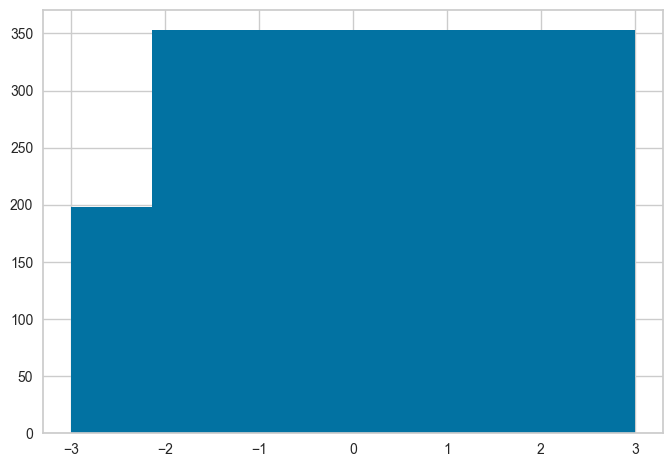

In [24]:
a,b = SVMSMOTE(random_state=42).fit_resample(X_train, y_train)
b.hist(bins=7)

# 1. Treinamento

In [26]:
# DECLARAÇÃO DE VARIÁVEIS
from datetime import datetime 
data= datetime.today().strftime('%Y.%m.%d_%H.%M.%S')
caminho_modelo_regressao = f'modelos/{data}_melhor_modelo_regressao'
features_data = ['hora','data','data_cplt']
variavel_resposta_selecionada='p1'
features_categoricas = ['sexo']
features_numericas = ['idade', 
                      'peso', 
                      'altura',
                      'vestimenta',
                      'tmedia', 
                      #'tmax', 
                      #'tmin',
                      'tu',
                      'ur',
                     # 'ur_max',
                     # 'ur_min',
                      'rsolarmed', 
                      #'rsolartot', 
                      'vel_vento',
                      #'dir_vento',
                      #'sd_dirvento',
                     # 'vel_vento_max',
                       # 'dir_max_vento',
                      'chuva_tot'
                      ]

features_numericas=['absolute_humidity_norm',
                    'rsolarmed',
                    'dir_max_vento']

features_categoricas=['mes-ano_encod','sexo_encod','vestimenta']

### 1.1.1 Modelos de regressão

In [30]:
# Importação de bibliotecas
import pandas as pd
from pycaret.regression import RegressionExperiment  # Import correto


# Carregando os dados
exp = RegressionExperiment()

# 1. Configuração inicial do PyCaret
exp.setup(
    data=df_features_selecionados,
    target=variavel_resposta_selecionada,
    #ignore_features=features_remocao,
    #date_features = features_data,
    #numeric_features=features_numericas,
    #categorical_features=features_categoricas,
    remove_outliers=True,
    pca=True,
    outliers_method='iforest',
    #fix_imbalance = True,
    session_id=123,  # Para reprodutibilidade
    normalize=True,  # Normaliza os dados
    #feature_interaction=True,  # Adiciona interações entre features
    #silent=True,  # Evita pausas durante a execução
    fold=5  # Validação cruzada com 5 divisões
)
metricas_df = exp.pull()
# 2. Comparação de modelos de regressão
print("Comparando os modelos...")
best_model = exp.compare_models()
#metricas_df = exp.pull()
# 3. Ajuste de hiperparâmetros no melhor modelo encontrado
print("Ajustando o melhor modelo...")
tuned_model = exp.tune_model(best_model)

# 4. Avaliação do modelo ajustado
print("Avaliando o modelo ajustado...")
#evaluate_model(tuned_model)  # Interface interativa para análise

# 5. Salvando o modelo treinado para futuras previsões
print("Salvando o modelo treinado...")
exp.save_model(tuned_model, caminho_modelo_regressao)

# 6. Carregando o modelo salvo
#print("Carregando o modelo salvo...")
#loaded_model = load_model("melhor_modelo_regressao")

# 7. Fazendo previsões em novos dados
print("Fazendo previsões...")
df_novos_dados = pd.read_csv("dados/dados_validacao.csv")  # Dados novos para predição
predictions = exp.predict_model(tuned_model, data=df_validacao)



,Description,Value
0,Session id,123
1,Target,p1
2,Target type,Regression
3,Original data shape,"(1720, 7)"
4,Transformed data shape,"(1659, 7)"
5,Transformed train set shape,"(1143, 7)"
6,Transformed test set shape,"(516, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


Comparando os modelos...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.7877,0.9326,0.9656,0.4868,0.4663,0.4633,0.0880
knn,K Neighbors Regressor,0.7997,0.9702,0.9844,0.4674,0.4699,0.4862,0.0500
ada,AdaBoost Regressor,0.8626,1.0268,1.0129,0.4364,0.4792,0.4769,0.0740
lightgbm,Light Gradient Boosting Machine,0.8392,1.0847,1.0411,0.4035,0.4974,0.5210,0.1480
rf,Random Forest Regressor,0.8448,1.0956,1.0462,0.3972,0.5004,0.5192,0.1200
et,Extra Trees Regressor,0.8856,1.2957,1.1376,0.2858,0.5496,0.5527,0.0900
dt,Decision Tree Regressor,0.9303,1.4721,1.2129,0.1897,0.5745,0.5918,0.0560
omp,Orthogonal Matching Pursuit,0.9565,1.4942,1.2162,0.1743,0.5261,0.5798,0.0440
br,Bayesian Ridge,0.9106,1.5152,1.2136,0.1579,0.5071,0.5603,0.0480
ridge,Ridge Regression,0.9108,1.5254,1.2169,0.1520,0.5078,0.5609,0.5720


Ajustando o melhor modelo...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8633,1.0579,1.0285,0.4255,0.4891,0.5024
1,0.7684,0.8630,0.9290,0.4739,0.4613,0.4511
2,0.8443,1.0131,1.0065,0.4765,0.4862,0.4870
3,0.7864,0.8834,0.9399,0.4842,0.4571,0.4549
4,0.8464,0.9966,0.9983,0.5014,0.4490,0.5073
Mean,0.8218,0.9628,0.9804,0.4723,0.4685,0.4805
Std,0.0373,0.0761,0.0390,0.0253,0.0161,0.0235


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Avaliando o modelo ajustado...
Salvando o modelo treinado...
Transformation Pipeline and Model Successfully Saved
Fazendo previsões...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.7146,0.7820,0.8843,0.5317,0.4454,0.4190


In [103]:
predictions['prediction_label'] = predictions['prediction_label'].apply(lambda x: round(x, 0)).astype(int)
mapa_num_para_classe = {0:-3,
                        1:-2,
                        2:-1,
                        3: 0,
                        4: 1,
                        5: 2,
                        6:3}
ordem_classes = [-3, -2, -1, 0, 1, 2, 3]

predictions['classe_original_prevista'] = predictions['prediction_label'].map(mapa_num_para_classe) #Valores previstos
predictions['classe_original_verdadeira'] = predictions[variavel_resposta_selecionada].map(mapa_num_para_classe)  # Valores previstos
predictions

,data,hora,idade,sexo,peso,altura,vestimenta,p2,p3,p4,...,absolute_humidity_norm,t*u_norm,t/u_norm,log(t)*u_norm,log(t*u)_norm,log(t/u)_norm,p1,prediction_label,classe_original_prevista,classe_original_verdadeira
599,2015-08-07,NaN,27,f,62,168,0.5,1,0,1,...,-1.186104,-0.988836,0.544738,-0.809250,-1.078853,0.607605,1,1,-2.0,-2.0
1514,2016-07-07,NaN,40,f,65,162,1.0,0,0,0,...,-1.181426,-1.132285,0.878608,-1.044655,-1.106995,0.903379,1,0,-3.0,-2.0
115,2015-08-05,NaN,19,f,61,163,1.0,0,-2,1,...,1.427235,1.421209,-1.254041,1.298536,1.412230,-1.187410,2,1,-2.0,-1.0
135,2015-08-05,NaN,59,m,82,165,1.0,0,1,0,...,1.423413,1.347847,-1.136500,1.141377,1.354175,-1.011516,2,2,-1.0,-1.0
339,2015-08-06,NaN,23,f,58,167,0.5,0,0,0,...,-0.912034,-0.752676,0.267920,-0.624334,-0.760892,0.411649,1,1,-2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,2016-07-07,NaN,47,f,79,173,1.0,1,2,1,...,-1.686763,-1.762216,1.392892,-1.423446,-1.795841,1.227689,2,0,-3.0,-1.0
1221,2016-01-19,NaN,22,f,53,163,0.5,2,-1,2,...,0.116813,-0.034592,-0.143381,-0.184933,0.101739,0.108787,3,2,-1.0,0.0
353,2015-08-06,NaN,21,m,65,174,0.5,1,-1,0,...,-0.707352,-0.589169,0.140657,-0.508514,-0.553672,0.315197,1,1,-2.0,-2.0
787,2015-08-07,NaN,24,m,100,182,0.5,1,-1,2,...,-0.327991,-0.557166,0.935545,-0.709317,-0.514248,0.856978,2,1,-2.0,-1.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.7877,0.9326,0.9656,0.4868,0.4663,0.4633,0.1300
knn,K Neighbors Regressor,0.7997,0.9702,0.9844,0.4674,0.4699,0.4862,0.0640
ada,AdaBoost Regressor,0.8626,1.0268,1.0129,0.4364,0.4792,0.4769,0.1060
lightgbm,Light Gradient Boosting Machine,0.8392,1.0847,1.0411,0.4035,0.4974,0.5210,0.1440
rf,Random Forest Regressor,0.8448,1.0956,1.0462,0.3972,0.5004,0.5192,0.2160
et,Extra Trees Regressor,0.8856,1.2957,1.1376,0.2858,0.5496,0.5527,0.1280
dt,Decision Tree Regressor,0.9303,1.4721,1.2129,0.1897,0.5745,0.5918,0.0620
omp,Orthogonal Matching Pursuit,0.9565,1.4942,1.2162,0.1743,0.5261,0.5798,0.0760
br,Bayesian Ridge,0.9106,1.5152,1.2136,0.1579,0.5071,0.5603,0.0560
ridge,Ridge Regression,0.9108,1.5254,1.2169,0.1520,0.5078,0.5609,0.0800


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.7146,0.7820,0.8843,0.5317,0.4454,0.4190


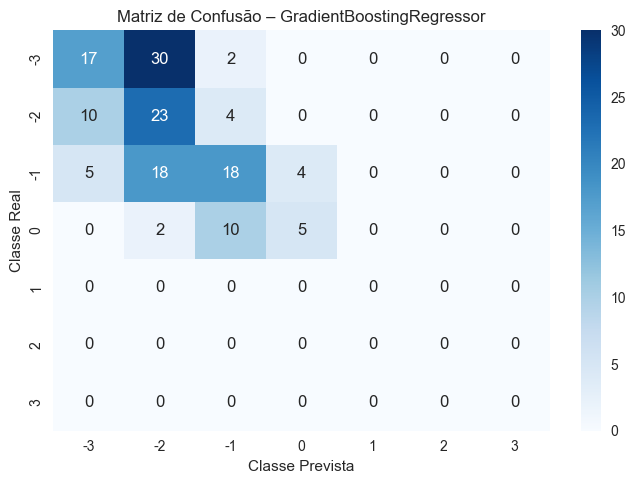

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.7233,0.7972,0.8929,0.5225,0.4368,0.4585


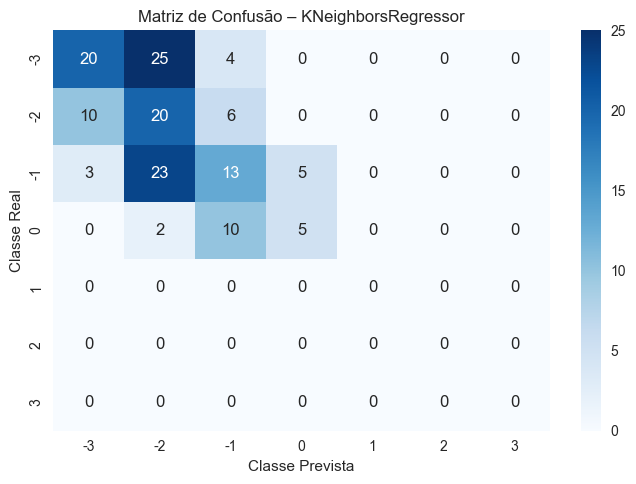

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.8593,1.0677,1.0333,0.3605,0.5063,0.4879


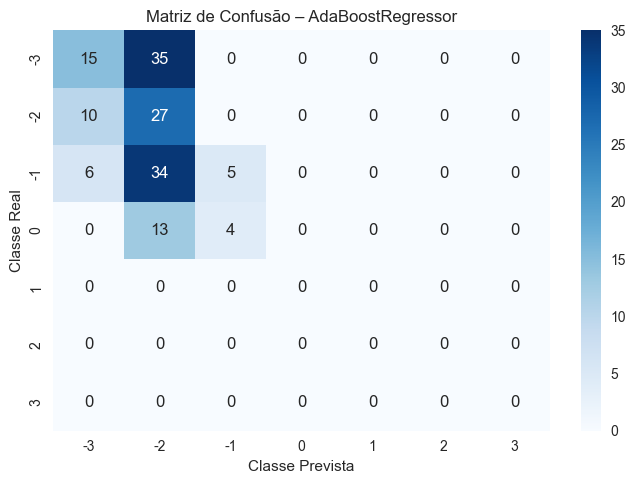

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6264,0.6465,0.8040,0.6128,0.3923,0.4154


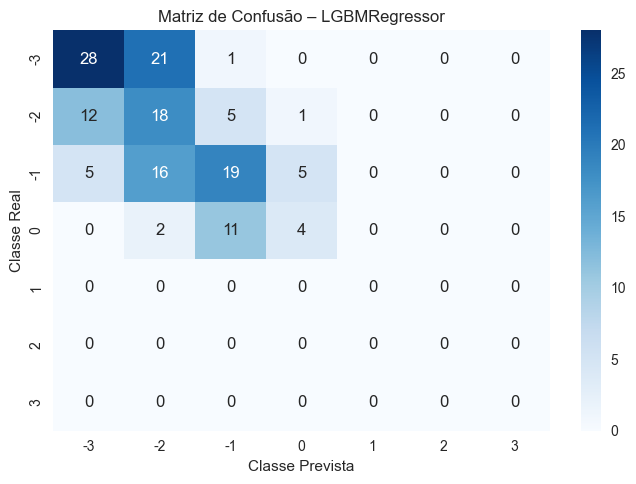

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.6143,0.6501,0.8063,0.6107,0.3838,0.4156


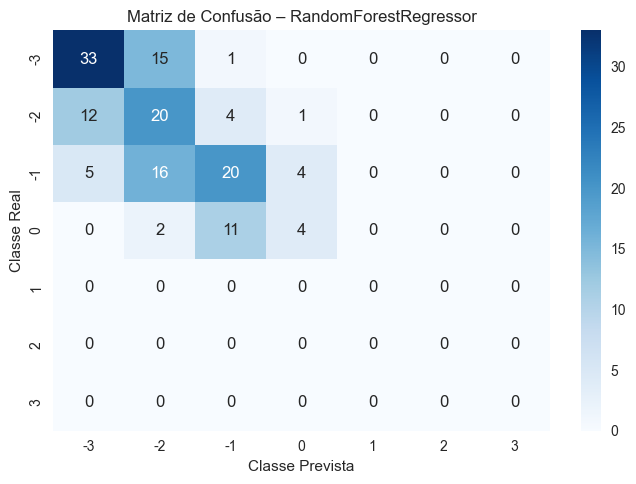

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5607,0.6700,0.8185,0.5987,0.3698,0.3914


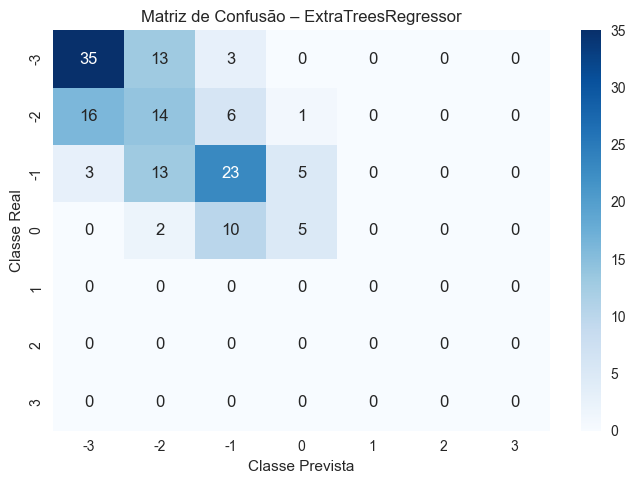

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.5811,0.7239,0.8508,0.5664,0.3964,0.4101


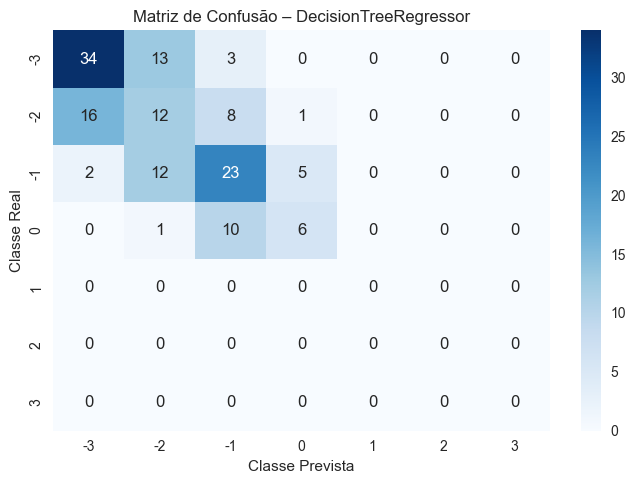

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.0401,2.7900,1.6703,-0.6710,0.5571,0.6431


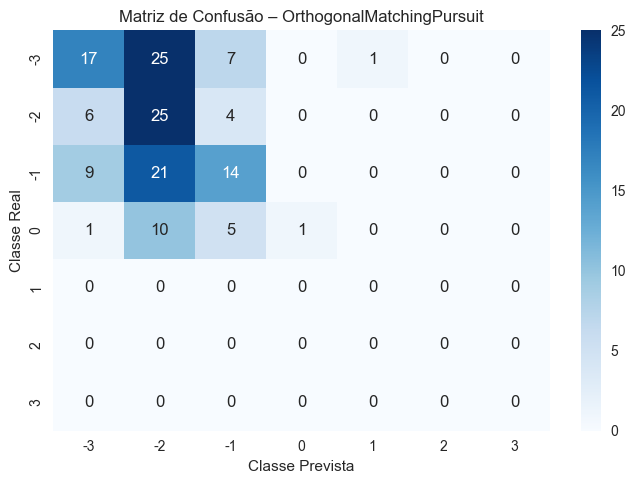

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.0550,3.6649,1.9144,-1.1950,0.5558,0.6501


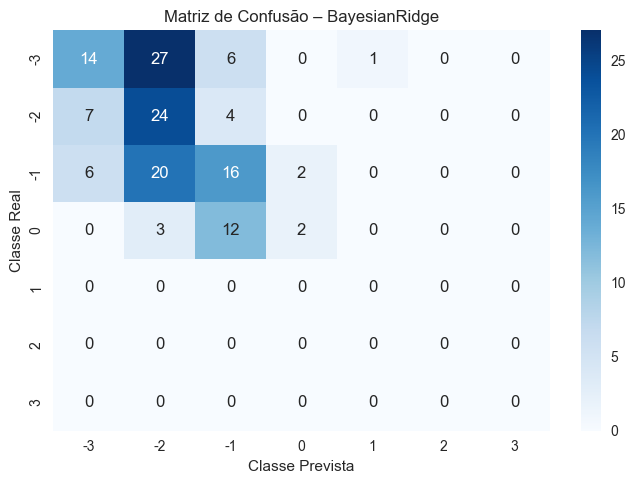

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.0579,3.7163,1.9278,-1.2258,0.5567,0.6521


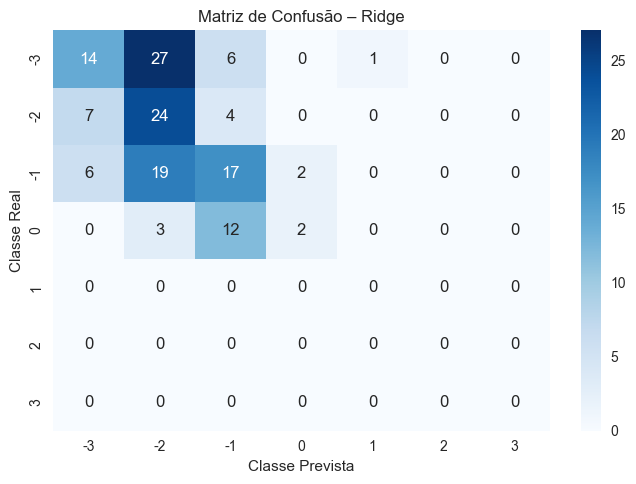

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Mapa de discretização e ordem de classes (mesmo que antes)
mapa_num_para_classe = {0: -3, 1: -2, 2: -1, 3: 0, 4: 1, 5: 2, 6: 3}
ordem_classes = [-3, -2, -1, 0, 1, 2, 3]

# Lista dos melhores modelos
modelos = exp.compare_models(n_select=10)

# Para cada modelo, gerar matriz de confusão
for modelo in modelos:
    nome = str(modelo).split('(')[0]
    preds = exp.predict_model(modelo, data=df_validacao)

    # Discretiza predições e valores reais
    preds['prediction_label'] = preds['prediction_label'].apply(lambda x: round(x)).astype(int)
    preds['classe_prevista'] = preds['prediction_label'].map(mapa_num_para_classe)
    preds['classe_real'] = preds[variavel_resposta_selecionada].map(mapa_num_para_classe)
    preds = preds.dropna(subset=['classe_prevista', 'classe_real'])

    y_true = preds['classe_real']
    y_pred = preds['classe_prevista']

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=ordem_classes)

    # Plot
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ordem_classes,
                yticklabels=ordem_classes)
    plt.xlabel("Classe Prevista")
    plt.ylabel("Classe Real")
    plt.title(f"Matriz de Confusão – {nome}")
    plt.tight_layout()
    plt.show()


In [53]:
df_resultados_regressao_como_classificacao.to_excel('tabelas/resultado_regressão_metricas_classif.xlsx')

In [54]:
metricas_df.to_excel('tabelas/resultado_regressão.xlsx')

In [ ]:
# Nome do arquivo YAML
import yaml
from datetime import datetime
import os

yaml_file = "registros_mlops_reg.yaml"
horario_atual = datetime.now().strftime("%Y/%m/%d-%H:%M:%S")

# Criar estrutura do YAML
config_data = {
    "mlops": {
        "sigla_melhor_mod": best_model_name,
        "nome_melhor_mod":dict_modelos[best_model_name],
        "version": "1.0",
        "caminho":caminho_modelo_regressao,
        "description": "Modelo escolhido com base em R^2.",
        "data_treinamento": horario_atual
    }
}


# Criar arquivo se ele não existir
if not os.path.exists(yaml_file):
    with open(yaml_file, "w") as file:
        yaml.dump(config_data, file, default_flow_style=False)
    print(f"Arquivo YAML criado: {yaml_file}")
else:
    with open(yaml_file, "w") as file:
        yaml.dump(config_data, file, default_flow_style=False)
    print(f"O arquivo {yaml_file} já existe.")

# 1.1.2 Classificação

In [114]:
# Subir
from pycaret.classification import *
caminho_modelo= 'modelos/melhor_modelo_classif'
exp = ClassificationExperiment()

# Configurar o ambiente do PyCaret

exp.setup(
    data=df_features_selecionados,
    target=variavel_resposta_selecionada,
    #ignore_features=features_remocao,

    #date_features = features_data,
    #numeric_features=features_numericas,
    #categorical_features=features_categoricas,

    remove_outliers=True,
    #pca=True,
    outliers_method='iforest',
    fix_imbalance = True,
    feature_selection=True,
    fix_imbalance_method = metodos['Tomek Links'],
    transformation=True,
    session_id=123,  # Para reprodutibilidade
    normalize=True,  # Normaliza os dados
    #feature_interaction=True,  # Adiciona interações entre features
    #silent=True,  # Evita pausas durante a execução
    fold=5  # Validação cruzada com 5 divisões
)

# Comparar todos os modelos e armazenar os resultados
exp.compare_models(n_select=10, fold=5, round=4, verbose=False)


# Extrair os resultados dos modelos para um DataFrame
df_results = exp.pull()

dict_modelos = df_results['Model'].to_dict()

model_names = df_results['Model']
# Remover a coluna de tempo de treinamento
df_filtered = df_results.drop(columns=['Model','TT (Sec)'])


# Calcular a média de cada métrica
metric_means = df_filtered.mean()

# Criar um DataFrame booleano indicando se cada métrica está acima da média
above_mean = df_filtered >= metric_means

# Contar quantas métricas estão acima da média para cada modelo
above_mean_count = above_mean.sum(axis=1)

# Filtrar modelos que não possuem métricas abaixo da média
valid_models = df_filtered[above_mean.all(axis=1)]


# Se houver modelos que atendem aos critérios, selecionar o que tem mais métricas acima da média
if not valid_models.empty:
    best_model_name = above_mean_count[valid_models.index].idxmax()
    best_model = exp.create_model(best_model_name)
else:
    # Caso nenhum atenda a todos os critérios, escolher o modelo com mais métricas acima da média
    best_model_name = above_mean_count.idxmax()
    best_model = exp.create_model(best_model_name)

tuned_model = exp.tune_model(best_model)
exp.save_model(tuned_model, caminho_modelo)

# 7. Fazendo previsões em novos dados
print("Fazendo previsões...")
df_novos_dados = pd.read_csv("dados/dados_validacao.csv")  # Dados novos para predição
predictions = exp.predict_model(tuned_model, data=df_validacao)


# Exibir o modelo escolhido
print(f"Melhor modelo com critério personalizado: {best_model}")

,Description,Value
0,Session id,123
1,Target,p1
2,Target type,Multiclass
3,Target mapping,"-3: 0, -2: 1, -1: 2, 0: 3, 1: 4, 2: 5, 3: 6"
4,Original data shape,"(1720, 7)"
5,Transformed data shape,"(1574, 2)"
6,Transformed train set shape,"(1058, 2)"
7,Transformed test set shape,"(516, 2)"
8,Numeric features,6
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.2697,0.5706,0.2697,0.2728,0.2707,0.0759,0.0760
1,0.3278,0.6098,0.3278,0.3185,0.3145,0.1277,0.1289
2,0.3112,0.6480,0.3112,0.3022,0.3061,0.1204,0.1206
3,0.3112,0.5896,0.3112,0.2954,0.3004,0.1049,0.1054
4,0.3625,0.6338,0.3625,0.3461,0.3461,0.1743,0.1767
Mean,0.3165,0.6104,0.3165,0.3070,0.3076,0.1207,0.1215
Std,0.0300,0.0282,0.0300,0.0244,0.0243,0.0322,0.0330


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3071,0.5646,0.3071,0.2585,0.2769,0.0951,0.0969
1,0.3485,0.6320,0.3485,0.2339,0.2681,0.1189,0.1368
2,0.3527,0.6284,0.3527,0.3048,0.3077,0.1384,0.1464
3,0.3444,0.5945,0.3444,0.2277,0.2701,0.1201,0.1319
4,0.3667,0.6357,0.3667,0.3122,0.2934,0.1526,0.1732
Mean,0.3439,0.6111,0.3439,0.2674,0.2832,0.1250,0.1371
Std,0.0199,0.0275,0.0199,0.0352,0.0151,0.0195,0.0246


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved
Fazendo previsões...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.3547,0.6551,0.3547,0.2895,0.3024,0.1303,0.1382


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Melhor modelo com critério personalizado: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=

In [116]:
df_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3348,0.0000,0.3348,0.2143,0.2587,0.1005,0.1110,0.560
lda,Linear Discriminant Analysis,0.3298,0.0000,0.3298,0.2069,0.2457,0.0849,0.0980,0.532
ridge,Ridge Classifier,0.3273,0.0000,0.3273,0.1811,0.2323,0.0757,0.0881,0.492
ada,Ada Boost Classifier,0.3256,0.0000,0.3256,0.2845,0.2620,0.0975,0.1057,0.868
nb,Naive Bayes,0.3239,0.6063,0.3239,0.1988,0.2379,0.0748,0.0860,0.464
qda,Quadratic Discriminant Analysis,0.3231,0.0000,0.3231,0.1954,0.2358,0.0732,0.0844,0.800
gbc,Gradient Boosting Classifier,0.3206,0.0000,0.3206,0.3027,0.3030,0.1160,0.1178,1.194
lightgbm,Light Gradient Boosting Machine,0.3165,0.6104,0.3165,0.3070,0.3076,0.1207,0.1215,1.322
dt,Decision Tree Classifier,0.3106,0.5900,0.3106,0.2981,0.3002,0.1072,0.1080,0.536
et,Extra Trees Classifier,0.3090,0.5917,0.3090,0.2997,0.3004,0.1077,0.1084,0.758


In [ ]:
# Lista dos melhores modelos
modelos = exp.compare_models(n_select=10)

# Para cada modelo, gerar matriz de confusão
for modelo in modelos:
    nome = str(modelo).split('(')[0]
    preds = exp.predict_model(modelo, data=df_validacao)

    # Discretiza predições e valores reais
    preds['prediction_label'] = preds['prediction_label'].apply(lambda x: round(x)).astype(int)
    preds['classe_prevista'] = preds['prediction_label'].map(mapa_num_para_classe)
    preds['classe_real'] = preds[variavel_resposta_selecionada].map(mapa_num_para_classe)
    preds = preds.dropna(subset=['classe_prevista', 'classe_real'])

    y_true = preds['classe_real']
    y_pred = preds['classe_prevista']

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=ordem_classes)

    # Plot
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ordem_classes,
                yticklabels=ordem_classes)
    plt.xlabel("Classe Prevista")
    plt.ylabel("Classe Real")
    plt.title(f"Matriz de Confusão – {nome}")
    plt.tight_layout()
    plt.show()


In [121]:
preds

,data,hora,idade,sexo,peso,altura,vestimenta,p2,p3,p4,...,t*u_norm,t/u_norm,log(t)*u_norm,log(t*u)_norm,log(t/u)_norm,p1,prediction_label,prediction_score,classe_prevista,classe_real
599,2015-08-07,NaN,27,f,62,168,0.5,1,0,1,...,-0.988836,0.544738,-0.809250,-1.078853,0.607605,1,0,0.5920,-3.0,-2.0
115,2015-08-05,NaN,19,f,61,163,1.0,0,-2,1,...,1.421209,-1.254041,1.298536,1.412230,-1.187410,2,0,0.4444,-3.0,-1.0
135,2015-08-05,NaN,59,m,82,165,1.0,0,1,0,...,1.347847,-1.136500,1.141377,1.354175,-1.011516,2,0,0.6000,-3.0,-1.0
339,2015-08-06,NaN,23,f,58,167,0.5,0,0,0,...,-0.752676,0.267920,-0.624334,-0.760892,0.411649,1,1,0.6667,-2.0,-2.0
694,2015-08-07,NaN,47,m,100,183,0.5,1,-1,0,...,-0.962203,1.172619,-0.934378,-1.041805,0.995265,2,2,0.6667,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,2016-07-07,NaN,47,f,79,173,1.0,1,2,1,...,-1.762216,1.392892,-1.423446,-1.795841,1.227689,2,1,0.6667,-2.0,-1.0
1221,2016-01-19,NaN,22,f,53,163,0.5,2,-1,2,...,-0.034592,-0.143381,-0.184933,0.101739,0.108787,3,1,0.4444,-2.0,0.0
353,2015-08-06,NaN,21,m,65,174,0.5,1,-1,0,...,-0.589169,0.140657,-0.508514,-0.553672,0.315197,1,0,0.7500,-3.0,-2.0
787,2015-08-07,NaN,24,m,100,182,0.5,1,-1,2,...,-0.557166,0.935545,-0.709317,-0.514248,0.856978,2,2,0.6667,-1.0,-1.0


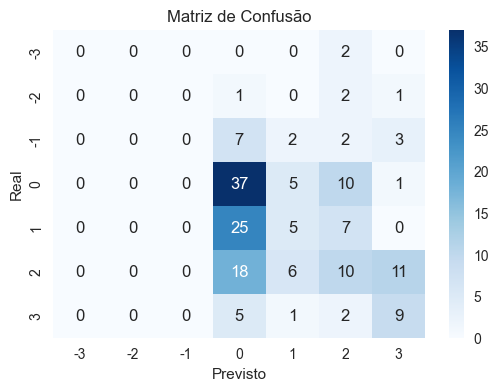

In [118]:
from sklearn.metrics import confusion_matrix

# Definir valores reais e previstos
y_true = predictions[variavel_resposta_selecionada]  # Valores reais
y_pred = predictions["prediction_label"]  # Previsões do modelo
y_pred=round(y_pred)
# Gerar matriz de confusão
cm = confusion_matrix(y_true, y_pred)
# Carregar os dados (substitua pelos seus DataFrames)
#df = pd.read_csv("dados_resultados.csv")  # Exemplo


# Criar matriz de confusão
matriz = confusion_matrix(y_true, y_pred)

# Ordenar os rótulos nos eixos
labels = sorted(set(y_true))  # Obtém os valores únicos e os ordena

# Exibir matriz como heatmap
plt.figure(figsize=(6,4))
sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

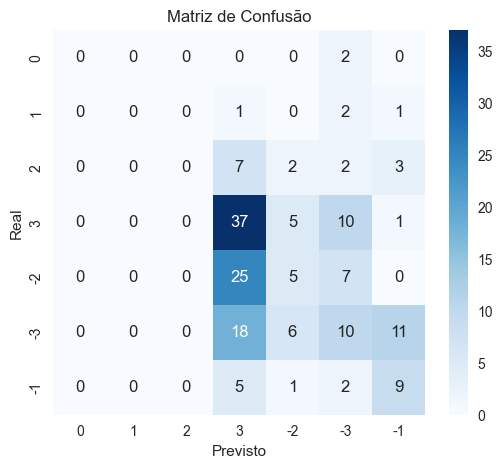

ValueError: at least one array or dtype is required

In [120]:

# Recarregar bibliotecas após reset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score, confusion_matrix
)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Calcular o AUC corretamente para problemas binários e multiclasse
if len(set(y_true)) > 2:
    # Selecionar colunas de probabilidades
    prob_cols = [col for col in predictions.columns if "prob" in col.lower()]
    auc = roc_auc_score(y_true, predictions[prob_cols], multi_class='ovr')
else:
    auc = roc_auc_score(y_true, y_pred)

# Calcular todas as métricas usadas pelo PyCaret
metricas_completas = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "AUC": auc,
    "Recall": recall_score(y_true, y_pred, average='weighted'),
    "Precision": precision_score(y_true, y_pred, average='weighted'),
    "F1 Score": f1_score(y_true, y_pred, average='weighted'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "MCC": matthews_corrcoef(y_true, y_pred)
}

# Converter para DataFrame e exibir as métricas
metricas_completas_df = pd.DataFrame([metricas_completas])


In [100]:
df_results.to_excel('tabelas/resultado_classificação.xlsx')